In [185]:
from qiskit import QuantumCircuit, execute, Aer

from pairwise_tomography.pairwise_state_tomography_circuits import pairwise_state_tomography_circuits
from pairwise_tomography.pairwise_fitter import PairwiseStateTomographyFitter
from pairwise_tomography.utils import concurrence
from pairwise_tomography.visualization import draw_entanglement_graph

from math import pi

In [313]:
class ParameterGraph ():
    
    def __init__ (self,num_qubits):
        
        self.num_qubits = num_qubits
        
        '''self.coupling_map = []
        for j in range(self.num_qubits-1):
            for k in range(j+1,self.num_qubits):
                if ([j,k] in coupling_map) or ([j,k] in coupling_map) or (not coupling_map):
                    self.coupling_map.append([j,k])'''
                    
        self.qc = QuantumCircuit(self.num_qubits)

        
    def transfer(self,params,control_params=None):
        
        def get_p (circuit):
            shots = 8192
            counts = execute(self.qc+test_meas,Aer.get_backend('qasm_simulator'),shots=shots).result().get_counts()
            if '0' in counts:
                p = counts['0']/shots
            else:
                p = 0
            return p
        
        def basis_change(basis,qubit,dagger=False):
            basis_change = QuantumCircuit(self.num_qubits)
            if basis=='X':
                basis_change.h(0)
            elif basis=='Y':
                if dagger:
                    basis_change.rx(pi/2,0)
                else:
                    basis_change.rx(-pi/2,0)
            return basis_change
        
        epsilon = 1/16

        source_pauli,sink_pauli,fraction,qubit = params
        
        test_meas = QuantumCircuit(self.num_qubits,1)
        test_meas += basis_change(sink_pauli,qubit)
        test_meas.measure(qubit,0)
        
        p_init = get_p(self.qc+test_meas)
        
        if control_params:
            self.qc += basis_change(control_params[0],control_params[1],dagger=True)
        
        paulis = [source_pauli,sink_pauli]
        if 'X' in paulis:
            if 'Y' in paulis:
                if control_params:
                    self.qc.crz(pi*epsilon,control_params[1],qubit)
                else:
                    self.qc.rz(pi*epsilon,qubit)
            elif 'Z' in paulis:
                if control_params:
                    self.qc.cry(pi*epsilon,control_params[1],qubit)
                else:
                    self.qc.ry(pi*epsilon,qubit)
        else:
            if control_params:
                self.qc.mcrx(pi*epsilon,[self.qc.qregs[0][control_params[1]]],self.qc.qregs[0][qubit])
            else:
                self.qc.rx(pi*epsilon,qubit)
                
        if control_params:
            self.qc += basis_change(control_params[0],control_params[1],dagger=False)
        
        p_final = get_p(self.qc+test_meas)
        
        fraction = fraction * (2*(p_final>p_init)-1)
        
        if control_params:
            delta = len(basis_change(control_params[0],control_params[1],dagger=False).data)
            self.qc.data[-1-delta][0].params[0] = pi*fraction
        else:
            self.qc.data[-1][0].params[0] = pi*fraction
    
    def controlled_transfer (self,params,control_params):
        
        if control_params[0][0]=='-':
            if control_params[0][1] in ['Z','Y']:
                self.transfer(['Z','Y',1,control_params[1]])
                self.transfer(params,control_params=[control_params[0][1],control_params[1]])
                self.transfer(['Z','Y',1,control_params[1]])
            else:
                self.transfer(['Z','X',1,control_params[1]])
                self.transfer(params,control_params=[control_params[0][1],control_params[1]])
                self.transfer(['Z','X',1,control_params[1]])  
        else:
            
            self.transfer(params,control_params=[control_params[0][1],control_params[1]])

    
    def swap (self):
        pass
        
        
    def get_entanglement (self):
        
        pw_tomo_circs = pairwise_state_tomography_circuits(self.qc, self.qc.qregs[0])
        
        job = execute(pw_tomo_circs, Aer.get_backend('qasm_simulator'), shots=8192)
        
        fitter = PairwiseStateTomographyFitter(job.result(), pw_tomo_circs, self.qc.qregs[0])
        
        fit_result = fitter.fit()
        
        pairwise_entanglement = {key: concurrence(value) for key, value in fit_result.items()}
        
        return pairwise_entanglement

In [331]:
g = ParameterGraph(5)

g.transfer(['Z','X',0.5,0])
g.controlled_transfer(['Y','Z',0.25,1],['+Z',0])

g.transfer(['Z','X',0.25,2])
g.controlled_transfer(['Y','Z',0.5,3],['+Z',2])
g.controlled_transfer(['Y','Z',0.5,4],['-Z',2])

g.controlled_transfer(['Y','Z',0.25,1],['+Z',3])
g.controlled_transfer(['Y','Z',0.25,1],['+Z',4])

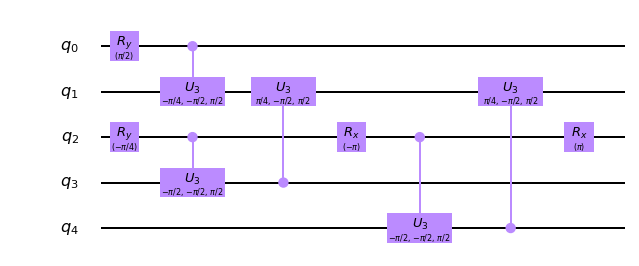

In [332]:
g.qc.draw(output='mpl')

In [333]:
pairwise_entanglement = g.get_entanglement()

for pair in pairwise_entanglement:
    print(pair,pairwise_entanglement[pair])

(0, 1) 0.33972532369927855
(0, 2) 0.0
(0, 3) 0.0
(0, 4) 0.0
(1, 2) 0.0
(1, 3) 0.0
(1, 4) 0.2330237391250059
(2, 3) 0.31376299171893673
(2, 4) 0.31626075313637153
(3, 4) 0.0
